<a href="https://colab.research.google.com/github/aramasethu/CS_573_project/blob/main/Notebook_with_EDA_charts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mounting google drive

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Mobility data

In [ ]:
mobility = pd.read_csv (r'/content/drive/MyDrive/CS_573_Group_project/Data/Global_Mobility_Report.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
mobility_country1 = mobility[mobility['sub_region_1'].isna()]
mobility_country = mobility_country1[mobility_country1['metro_area'].isna()]

In [ ]:
mobility_country = mobility_country.drop(columns=['country_region_code','sub_region_1', 'sub_region_2','metro_area', 'iso_3166_2_code','census_fips_code','place_id'])

In [ ]:
mobility_country['date'] = mobility_country['date'].astype('datetime64[ns]')

In [ ]:
mobility_country = mobility_country.rename(columns={ 'country_region': 'country'})

## Vaccination data loading

In [ ]:
vec_cases = pd.read_csv(r'/content/drive/MyDrive/CS_573_Group_project/Data/owid-covid-data.csv')

In [ ]:
vec_cases_scraped = vec_cases[['location', 'date', 'total_cases', 'total_deaths', 'population', 'new_people_vaccinated_smoothed']]

In [ ]:
vec_cases_new = vec_cases_scraped.copy()

In [ ]:
vec_cases_new['total_cases'] = vec_cases_new['total_cases'].replace(np.nan, 0)
vec_cases_new['total_deaths'] = vec_cases_new['total_deaths'].replace(np.nan, 0)
#vec_cases_new['new_vaccinations_smoothed'] = vec_cases_new['new_vaccinations_smoothed'].replace(np.nan, 0)
vec_cases_new['new_people_vaccinated_smoothed'] = vec_cases_new['new_people_vaccinated_smoothed'].replace(np.nan, 0)

In [ ]:
vec_cases_new['date'] = pd.to_datetime(vec_cases_new['date']).dt.strftime('%Y/%m/%d')

In [ ]:
vec_cases_new = vec_cases_new.rename(columns={'location': 'country'})

In [ ]:
vec_cases_new['date'] = vec_cases_new['date'].astype('datetime64[ns]')

## Lockdown data

In [ ]:
lockdown = pd.read_excel (r'/content/drive/MyDrive/CS_573_Group_project/Data/OxCGRT_timeseries_all.xlsx')

In [ ]:
lockdown_new = lockdown.drop(columns={"country_name","country_code"})
lockdown_new.columns = pd.to_datetime(lockdown_new.columns)

In [ ]:
lockdown_input = pd.DataFrame(columns=["country_name","lockdown_index","date"])
for i in range(lockdown_new.shape[1]):
  country = lockdown[{"country_name"}]
  index = lockdown_new.iloc[:,i]
  index_con = pd.concat([country,index], axis=1, ignore_index=True)
  index_con["date"] = index.name
  index_con = index_con.rename(columns={0: 'country_name',  1: 'lockdown_index'})
  lockdown_input = pd.concat([lockdown_input,index_con],ignore_index=True)

In [ ]:
lockdown_input = lockdown_input.sort_values('country_name',ascending=True)

In [ ]:
lockdown_input = lockdown_input.rename(columns={"country_name":"country"})

## Merge all datasets

In [ ]:
df_merged1 = vec_cases_new.merge(mobility_country, on=['country', 'date'])

In [ ]:
df_merged1.shape

(97134, 12)

In [ ]:
df_merged = df_merged1.merge(lockdown_input, on=['country', 'date'])

In [ ]:
df_merged['weekday'] = df_merged['date'].dt.dayofweek

In [ ]:
## correlation plot

In [ ]:
df_merged.dtypes

country                                                       object
date                                                  datetime64[ns]
total_cases                                                  float64
total_deaths                                                 float64
population                                                   float64
new_people_vaccinated_smoothed                               float64
retail_and_recreation_percent_change_from_baseline           float64
grocery_and_pharmacy_percent_change_from_baseline            float64
parks_percent_change_from_baseline                           float64
transit_stations_percent_change_from_baseline                float64
workplaces_percent_change_from_baseline                      float64
residential_percent_change_from_baseline                     float64
lockdown_index                                               float64
weekday                                                        int64
dtype: object

In [ ]:
df_merged_summary = df_merged.iloc[:,2:13]

In [ ]:
df_merged_summary.dtypes

total_cases                                           float64
total_deaths                                          float64
population                                            float64
new_people_vaccinated_smoothed                        float64
retail_and_recreation_percent_change_from_baseline    float64
grocery_and_pharmacy_percent_change_from_baseline     float64
parks_percent_change_from_baseline                    float64
transit_stations_percent_change_from_baseline         float64
workplaces_percent_change_from_baseline               float64
residential_percent_change_from_baseline              float64
lockdown_index                                        float64
dtype: object

In [ ]:
import plotly.express as px
fig = px.scatter_matrix(scatter_df, height=900, width=800)
fig.show()

In [ ]:
mapping = {df_merged_summary.columns[0]: 'cases', df_merged_summary.columns[1]: 'deaths',\
           df_merged_summary.columns[2]: 'pop', \
           df_merged_summary.columns[3]: 'vacc', \
           df_merged_summary.columns[4]: 'ret_mob', df_merged_summary.columns[5]: 'groc_mob',\
           df_merged_summary.columns[6]: 'parks_mob', df_merged_summary.columns[7]: 'trans_mob',\
           df_merged_summary.columns[8]: 'work_mob', df_merged_summary.columns[9]: 'res_mob', 
           df_merged_summary.columns[10]:'lockdown'}
df_merged_summary = df_merged_summary.rename(columns=mapping)

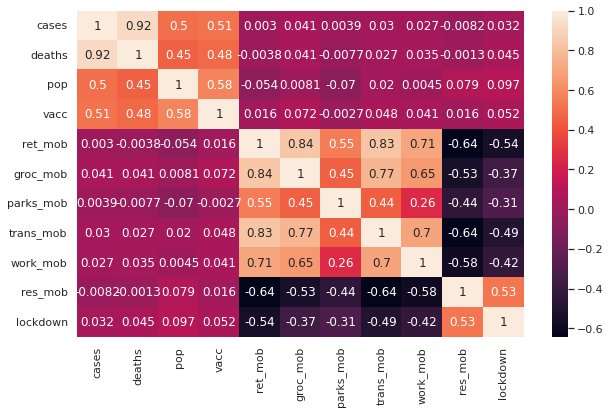

In [ ]:
corrMatrix = df_merged_summary.corr()
sns.set(rc = {'figure.figsize':(10,6)})
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
expla_df = df_merged_summary[['cases','deaths', 'vacc', 'lockdown']]

In [ ]:
def scatter_matrix_lowess(frame, alpha=0.5, figsize=None, grid=False,
                   diagonal='hist', marker='.', density_kwds=None,
                   hist_kwds=None, range_padding=0.05, **kwds):
    """
    Draw a matrix of scatter plots with lowess smoother.
    This is an adapted version of the pandas scatter_matrix function.

    Parameters
    ----------
    frame : DataFrame
    alpha : float, optional
        amount of transparency applied
    figsize : (float,float), optional
        a tuple (width, height) in inches
    ax : Matplotlib axis object, optional
    grid : bool, optional
        setting this to True will show the grid
    diagonal : {'hist', 'kde'}
        pick between 'kde' and 'hist' for
        either Kernel Density Estimation or Histogram
        plot in the diagonal
    marker : str, optional
        Matplotlib marker type, default '.'    
    hist_kwds : other plotting keyword arguments
        To be passed to hist function
    density_kwds : other plotting keyword arguments
        To be passed to kernel density estimate plot
    range_padding : float, optional
        relative extension of axis range in x and y
        with respect to (x_max - x_min) or (y_max - y_min),
        default 0.05
    kwds : other plotting keyword arguments
        To be passed to scatter function

    Examples
    --------
    >>> df = DataFrame(np.random.randn(1000, 4), columns=['A','B','C','D'])
    >>> scatter_matrix_lowess(df, alpha=0.2)
    """

    import matplotlib.pyplot as plt
    from matplotlib.artist import setp
    import pandas.core.common as com
    from pandas.compat import range, lrange, lmap, map, zip
    from statsmodels.nonparametric.smoothers_lowess import lowess

    df = frame._get_numeric_data()
    n = df.columns.size
    fig, axes = plt.subplots(nrows=n, ncols=n, figsize=figsize, squeeze=False)

    # no gaps between subplots
    fig.subplots_adjust(wspace=0, hspace=0)

    mask = com.notnull(df)

    marker = _get_marker_compat(marker)

    hist_kwds = hist_kwds or {}
    density_kwds = density_kwds or {}

    # workaround because `c='b'` is hardcoded in matplotlibs scatter method
    kwds.setdefault('c', plt.rcParams['patch.facecolor'])

    boundaries_list = []
    for a in df.columns:
        values = df[a].values[mask[a].values]
        rmin_, rmax_ = np.min(values), np.max(values)
        rdelta_ext = (rmax_ - rmin_) * range_padding / 2.
        boundaries_list.append((rmin_ - rdelta_ext, rmax_+ rdelta_ext))

    for i, a in zip(lrange(n), df.columns):
        for j, b in zip(lrange(n), df.columns):
            ax = axes[i, j]

            if i == j:
                values = df[a].values[mask[a].values]

                # Deal with the diagonal by drawing a histogram there.
                if diagonal == 'hist':
                    ax.hist(values, **hist_kwds)

                elif diagonal in ('kde', 'density'):
                    from scipy.stats import gaussian_kde
                    y = values
                    gkde = gaussian_kde(y)
                    ind = np.linspace(y.min(), y.max(), 1000)
                    ax.plot(ind, gkde.evaluate(ind), **density_kwds)

                ax.set_xlim(boundaries_list[i])

            else:
                common = (mask[a] & mask[b]).values

                ax.scatter(df[b][common], df[a][common],
                           marker=marker, alpha=alpha, **kwds)
                # The following 2 lines are new and add the lowess smoothing
                ys = lowess(df[a][common], df[b][common])
                ax.plot(ys[:,0], ys[:,1], 'red', linewidth=1)

                ax.set_xlim(boundaries_list[j])
                ax.set_ylim(boundaries_list[i])

            ax.set_xlabel('')
            ax.set_ylabel('')

            _label_axis(ax, kind='x', label=b, position='bottom', rotate=True)

            _label_axis(ax, kind='y', label=a, position='left')

            if j!= 0:
                ax.yaxis.set_visible(False)
            if i != n-1:
                ax.xaxis.set_visible(False)

    for ax in axes.flat:
        setp(ax.get_xticklabels(), fontsize=8)
        setp(ax.get_yticklabels(), fontsize=8)
    return fig

def _label_axis(ax, kind='x', label='', position='top',
    ticks=True, rotate=False):

    from matplotlib.artist import setp
    if kind == 'x':
        ax.set_xlabel(label, visible=True)
        ax.xaxis.set_visible(True)
        ax.xaxis.set_ticks_position(position)
        ax.xaxis.set_label_position(position)
        if rotate:
            setp(ax.get_xticklabels(), rotation=90)
    elif kind == 'y':
        ax.yaxis.set_visible(True)
        ax.set_ylabel(label, visible=True)
        # ax.set_ylabel(a)
        ax.yaxis.set_ticks_position(position)
        ax.yaxis.set_label_position(position)
    return

def _get_marker_compat(marker):
    import matplotlib.lines as mlines
    import matplotlib as mpl
    if mpl.__version__ < '1.1.0' and marker == '.':
        return 'o'
    if marker not in mlines.lineMarkers:
        return 'o'
    return marker

In [ ]:
import pandas as pd
import numpy as np
fig = scatter_matrix_lowess(expla_df, alpha=0.4, figsize=(12,12));


ImportError: ignored

In [ ]:
from sklearn.preprocessing import StandardScaler
trans = StandardScaler()
data = trans.fit_transform(expla_df)
dataset = pd.DataFrame(data)

In [ ]:
dataset.describe()

,0,1,2,3
count,9.271900e+04,9.271900e+04,9.271900e+04,9.189400e+04
mean,-1.659353e-16,-3.831906e-15,7.094100e-15,-9.588891e-16
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-2.521982e-01,-2.934737e-01,-1.801540e-01,-2.790426e+00
25%,-2.499490e-01,-2.914655e-01,-1.801540e-01,-6.589519e-01
50%,-2.288220e-01,-2.725662e-01,-1.792984e-01,3.619197e-02
75%,-1.304561e-01,-1.569352e-01,-1.316759e-01,7.778790e-01
max,1.840582e+01,1.306481e+01,3.207041e+01,2.214209e+00


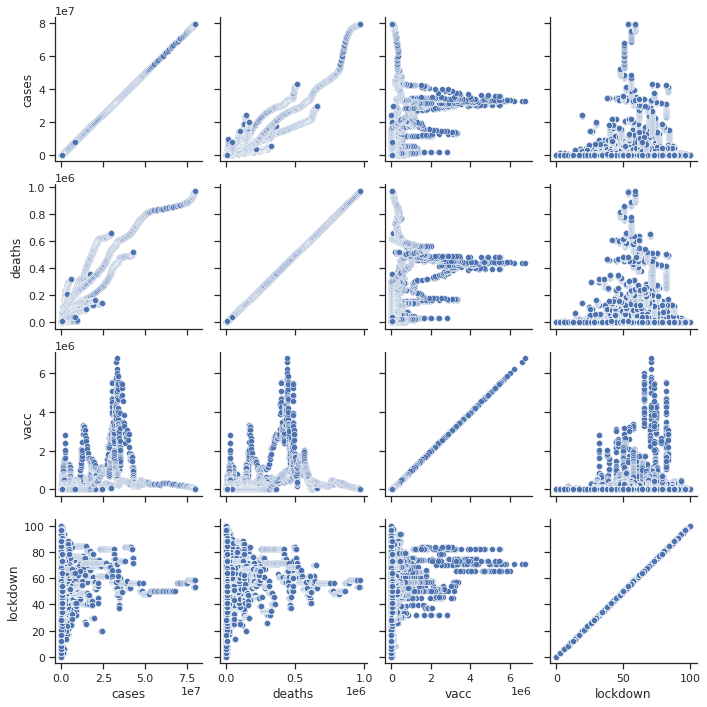

In [ ]:
import seaborn as sns

sns.pairplot(expla_df, diag_kind=None)

In [ ]:
import pandas as pd # for data manipulation
import numpy as np # for data manipulation
from sklearn.linear_model import LinearRegression # to build a LR model for comparison
import plotly.graph_objects as go # for data visualization
import plotly.express as px # for data visualization 
import statsmodels.api as sm # to build a LOWESS model
from scipy.interpolate import interp1d # for interpolation of new data points

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
expla_df.dtypes

cases       float64
deaths      float64
vacc        float64
lockdown    float64
dtype: object

In [ ]:
fig = px.scatter(expla_df, x=expla_df['cases'], y=expla_df['lockdown'], 
                 opacity=0.8, color_discrete_sequence=['black'])
# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')
fig.update_layout(title=dict(text="Relationship between lockdown index and cases", 
                             font=dict(color='black')))

fig.update_traces(marker=dict(size=3))

fig.show()



In [ ]:
# Generate y_hat values using lowess, try a couple values for hyperparameters
y_hat1 = lowess(y, x) # note, default frac=2/3
y_hat2 = lowess(y, x, frac=1/5)

NameError: ignored

In [ ]:
def lowess(x, y, f=1./3.):

    # get some paras
    xwidth = f*(x.max()-x.min()) # effective width after reduction factor
    N = len(x) # number of obs
    # Don't assume the data is sorted
    order = np.argsort(x)
    # storage
    y_sm = np.zeros_like(y)
    y_stderr = np.zeros_like(y)
    # define the weigthing function -- clipping too!
    tricube = lambda d : np.clip((1- np.abs(d)**3)**3, 0, 1)
    # run the regression for each observation i
    for i in range(N):
        dist = np.abs((x[order][i]-x[order]))/xwidth
        w = tricube(dist)
        # form linear system with the weights
        A = np.stack([w, x[order]*w]).T
        b = w * y[order]
        ATA = A.T.dot(A)
        ATb = A.T.dot(b)
        # solve the syste
        sol = np.linalg.solve(ATA, ATb)
        # predict for the observation only
        yest = A[i].dot(sol)# equiv of A.dot(yest) just for k
        place = order[i]
        y_sm[place]=yest 
        sigma2 = (np.sum((A.dot(sol) -y [order])**2)/N )
        # Calculate the standard error
        y_stderr[place] = np.sqrt(sigma2 * 
                                A[i].dot(np.linalg.inv(ATA)
                                                    ).dot(A[i]))
    return y_sm, y_stderr


import numpy as np
import matplotlib.pyplot as plt


# make some data
x = expla_df['cases']
y = expla_df['vacc']
order = np.argsort(x)

#run it
y_sm, y_std = lowess(x, y, f=1./5.)
# # plot it
plt.plot(x[order], y_sm[order], color='tomato', label='LOWESS')



KeyboardInterrupt: ignored

In [ ]:
df_merged_scatter.head()

NameError: ignored

In [ ]:
df_merged_summary.head()

,cases,deaths,pop,vacc,ret_mob,groc_mob,parks_mob,trans_mob,work_mob,res_mob,lockdown
0,5.0,0.0,39835428.0,0.0,3.0,13.0,4.0,9.0,7.0,0.0,8.33
1,5.0,0.0,39835428.0,0.0,2.0,5.0,1.0,9.0,7.0,0.0,8.33
2,5.0,0.0,39835428.0,0.0,-1.0,5.0,2.0,3.0,5.0,1.0,8.33
3,5.0,0.0,39835428.0,0.0,-1.0,0.0,1.0,3.0,7.0,2.0,8.33
4,5.0,0.0,39835428.0,0.0,-2.0,5.0,1.0,4.0,5.0,2.0,8.33


In [ ]:
df_merged_summary=df_merged_summary[['cases','deaths','vacc','work_mob','res_mob','lockdown']]

In [ ]:
df_merged_summary.describe()

,cases,deaths,vacc,work_mob,res_mob,lockdown
count,9.271900e+04,92719.000000,9.271900e+04,92357.000000,91925.000000,91894.000000
mean,1.077766e+06,21335.866910,3.790336e+04,-15.588824,6.716280,55.756831
std,4.273509e+06,72701.510413,2.103954e+05,22.194297,8.621877,19.981583
min,0.000000e+00,0.000000,0.000000e+00,-99.000000,-77.000000,0.000000
25%,9.612000e+03,146.000000,0.000000e+00,-27.000000,1.000000,42.590000
50%,9.989800e+04,1520.000000,1.800000e+02,-15.000000,6.000000,56.480000
75%,5.202635e+05,9926.500000,1.019950e+04,-3.000000,11.000000,71.300000
max,7.973479e+07,971162.000000,6.785334e+06,202.000000,55.000000,100.000000
